# Plots of extreme indices

In [2]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import seaborn as sns
import scipy.stats # to calculate correlation
import math
from matplotlib.ticker import FormatStrFormatter # to change the axis labels so they have no decimal places

In [3]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR
import Extreme_indices_functions as funcX
# import obs_functions as funcO

In [4]:
# define path where obs data is store
path = '/g/data/w48/kb6999/Observations/obs_netcdfs_T/'

In [5]:
# open daily T data from 5 stations 
daily_T = xr.open_dataset(f'{path}Daily_T_Aus_5S.nc')
daily_T

<xarray.Dataset>
Dimensions:  (station: 5, time: 15705)
Coordinates:
  * time     (time) datetime64[ns] 1878-01-01 1878-01-02 ... 1920-12-31
  * station  (station) object 'Adelaide (030420)' ... 'Sydney (066062)'
Data variables:
    Tmin     (station, time) float64 ...
    Tmax     (station, time) float64 ...

In [6]:
# take the seasonal mean
dataset = daily_T
# first I need to define a new coordinate (seasonyear) so that december gets counted with the adjoining jan and feb
seasonyear = (dataset.time.dt.year + (dataset.time.dt.month//12)) 
dataset.coords['seasonyear'] = seasonyear

# group data into seasons and calculate the seasonal mean for each year in the dataset 
season_mean_T = dataset.groupby('seasonyear').apply(func.seasonal_mean)
season_mean_T

<xarray.Dataset>
Dimensions:     (season: 4, seasonyear: 44, station: 5)
Coordinates:
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * station     (station) object 'Adelaide (030420)' ... 'Sydney (066062)'
  * seasonyear  (seasonyear) int64 1878 1879 1880 1881 ... 1918 1919 1920 1921
Data variables:
    Tmin        (seasonyear, season, station) float64 17.52 13.59 ... nan nan
    Tmax        (seasonyear, season, station) float64 31.17 28.24 ... nan nan

In [7]:
# Krakatoa years
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [8]:
# select out 10 years around Krakatoa
# K_daily_T = daily_T.sel(time=slice(e_pre5yrs[0], e_post5yrs[0]))
K_s_mean_T = season_mean_T.sel(seasonyear=slice('1878', '1888'))

In [9]:
# open netcdf of extreme indices
ex_index_s = xr.open_dataset(f'{path}Obs_extreme_indices_s.nc')
ex_index_s

<xarray.Dataset>
Dimensions:     (season: 4, seasonyear: 44, station: 5, time: 43)
Coordinates:
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * station     (station) object 'Adelaide (030420)' ... 'Sydney (066062)'
  * seasonyear  (seasonyear) int64 1878 1879 1880 1881 ... 1918 1919 1920 1921
  * time        (time) datetime64[ns] 1878-01-01 1879-01-01 ... 1919-12-23
Data variables: (12/14)
    FD          (station, seasonyear, season) float64 ...
    SU          (station, seasonyear, season) float64 ...
    ID          (station, seasonyear, season) float64 ...
    TR          (station, seasonyear, season) float64 ...
    TXx         (station, seasonyear, season) float64 ...
    TNx         (station, seasonyear, season) float64 ...
    ...          ...
    TN10p       (station, season, time) float64 ...
    TX10p       (station, season, time) float64 ...
    TN90p       (station, season, time) float64 ...
    TX90p       (station, season, time) float64 ...
    DTR         (season, station, time) float64 ...
    ETR         (station, seasonyear, season) float64 ...

In [10]:
# take the 10 years around Krakatoa
K_ex_index_s = ex_index_s.sel(seasonyear=slice('1878', '1888'))
K_ex_index_s

<xarray.Dataset>
Dimensions:     (season: 4, seasonyear: 11, station: 5, time: 43)
Coordinates:
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * station     (station) object 'Adelaide (030420)' ... 'Sydney (066062)'
  * seasonyear  (seasonyear) int64 1878 1879 1880 1881 ... 1885 1886 1887 1888
  * time        (time) datetime64[ns] 1878-01-01 1879-01-01 ... 1919-12-23
Data variables: (12/14)
    FD          (station, seasonyear, season) float64 0.0 2.0 0.0 ... 0.0 0.0
    SU          (station, seasonyear, season) float64 52.0 1.0 ... 15.0 13.0
    ID          (station, seasonyear, season) float64 0.0 0.0 0.0 ... 0.0 0.0
    TR          (station, seasonyear, season) float64 15.0 0.0 12.0 ... 0.0 1.0
    TXx         (station, seasonyear, season) float64 44.7 26.2 ... 33.8 33.8
    TNx         (station, seasonyear, season) float64 28.4 14.5 ... 19.2 20.6
    ...          ...
    TN10p       (station, season, time) float64 3.39 7.778 8.791 ... 9.89 6.593
    TX10p       (station, season, time) float64 1.695 5.556 ... 4.396 5.495
    TN90p       (station, season, time) float64 8.475 10.0 19.78 ... 8.791 7.692
    TX90p       (station, season, time) float64 8.475 13.33 ... 13.19 14.29
    DTR         (season, station, time) float64 13.65 13.86 ... 9.326 8.846
    ETR         (station, seasonyear, season) float64 34.5 25.8 ... 27.9 26.7

## Figures

In [11]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [12]:
# use this to set the x-ticks for each month from 5 years before to 5 years after the eruption
months = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='MS')
years = pd.date_range(e_pre5yrs[0], e_post5yrs[0], freq='YS')

## extreme indices

In [13]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [14]:
blues = sns.color_palette("Blues_r")
greens = sns.color_palette("Greens_r")
reds = sns.color_palette("Reds_r")
oranges = sns.color_palette("Oranges_r")

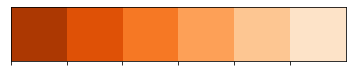

In [15]:
sns.palplot(sns.color_palette("Oranges_r"))

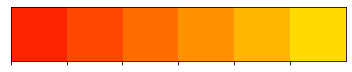

In [16]:
sns.palplot(sns.color_palette("autumn"))

In [17]:
# define this array so can call the season's in chronological order in my graphs
season_order = ['DJF', 'MAM', 'JJA', 'SON']

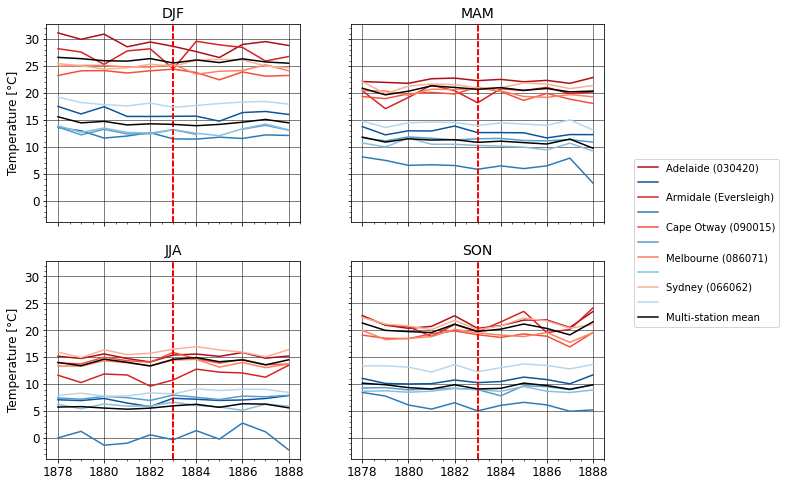

In [18]:
# plot by season
# define the datasets to plot on each graph
ds = K_s_mean_T.Tmax
ds2 = K_s_mean_T.Tmin

row = 2 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 2
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(10,8)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(season=season_order[m-1])
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k')

        axes[r, m-rmin].set(ylabel=None, title = season_order[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.15, 0.5)) 

plt.savefig('O_timeseries_monthly_Tmax+Tmin+msm_by_season.png', dpi=300, bbox_inches='tight')

<ipython-input-19-bcae82cc561e>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-19-bcae82cc561e>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-19-bcae82cc561e>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-19-bcae82cc561e>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)


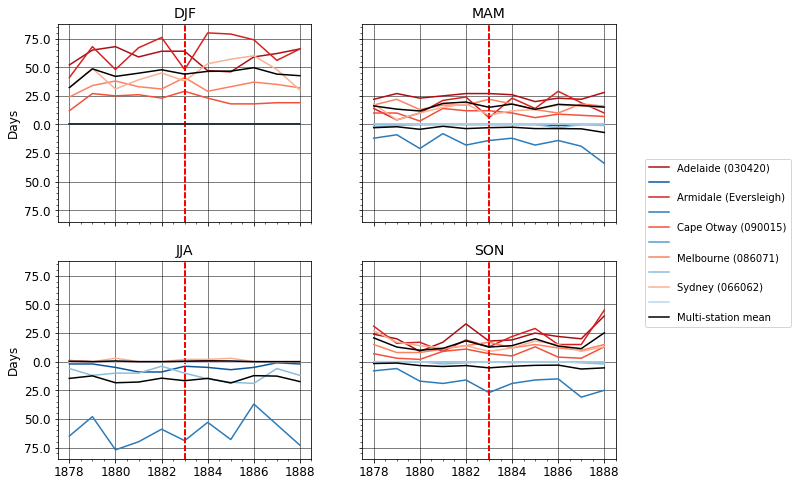

In [19]:
# plot by season
# define the datasets to plot on each graph
ds = K_ex_index_s.SU
ds2 = -K_ex_index_s.FD

row = 2 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 2
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(10,8)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(season=season_order[m-1])
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(season = season_order[m-1]).plot(ax = axes[r, m-rmin], color='k')

        axes[r, m-rmin].set(ylabel=None, title = season_order[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # change the labels so that FD values are no longer listed as negative (basically inverse operation)
        labels = axes[r, m-rmin].get_yticks().tolist()
        for l in range(0,math.floor(len(labels)/2)):
            labels[l] = labels[-(1+l)]
        # set the new labels
        axes[r, m-rmin].set_yticklabels(labels)
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Days')

    rmin = rmax
    rmax = rmin+col

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.15, 0.5)) 

plt.savefig('O_timeseries_monthly_SU+FD+msm_by_season.png', dpi=300, bbox_inches='tight')

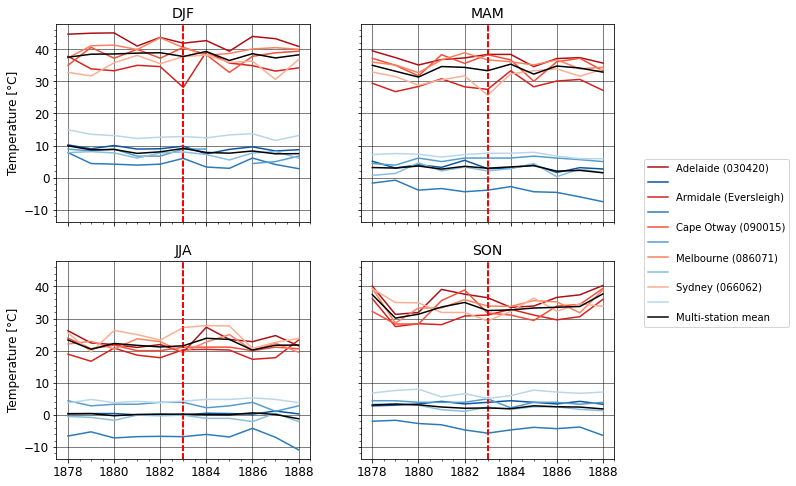

In [20]:
# plot by season
# define the datasets to plot on each graph
ds = K_ex_index_s.TXx
ds2 = K_ex_index_s.TNn

row = 2 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 2
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(10,8)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(season=season_order[m-1])
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k')

        axes[r, m-rmin].set(ylabel=None, title = season_order[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.15, 0.5)) 

plt.savefig('O_timeseries_monthly_TXx+TNn+msm_by_season.png', dpi=300, bbox_inches='tight')

In [38]:
labels[0]

-40.0

<ipython-input-39-b93d58adb79a>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-39-b93d58adb79a>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-39-b93d58adb79a>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)
<ipython-input-39-b93d58adb79a>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[r, m-rmin].set_yticklabels(labels)


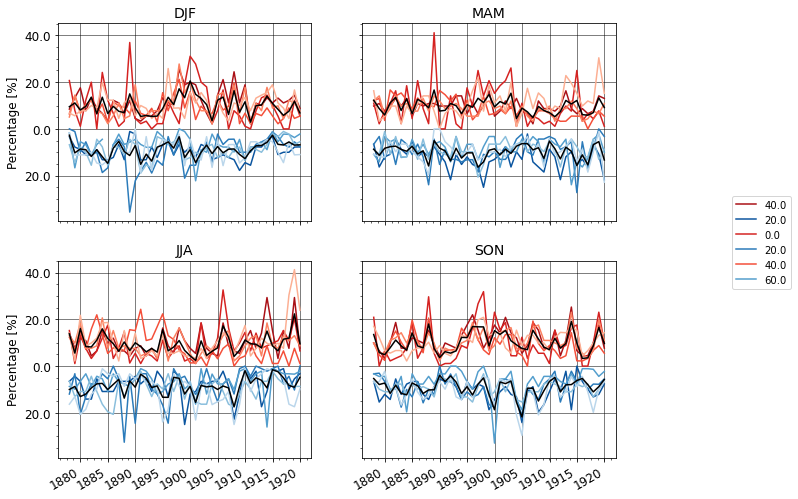

In [39]:
# plot by season
# define the datasets to plot on each graph
ds = K_ex_index_s.TX90p
ds2 = -K_ex_index_s.TN10p

row = 2 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 2
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(10,8)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(season=season_order[m-1])
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
            ds2.sel(station=s).sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color=blues[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
        ds2.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k')

        axes[r, m-rmin].set(ylabel=None, title = season_order[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # change the labels so that FD values are no longer listed as negative (basically inverse operation)
        labels = axes[r, m-rmin].get_yticks().tolist()
        for l in range(0,math.floor(len(labels)/2)):
            # if label is negative, change it to a positive of itself
            if labels[l] <0: 
                labels[l] = -labels[l]
        # set the new labels
        axes[r, m-rmin].set_yticklabels(labels)
        
        # make one legend for all tables (just use last axis to get info)  
#         handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Percentage [%]')

    rmin = rmax
    rmax = rmin+col

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.15, 0.5)) 

plt.savefig('O_timeseries_monthly_TX90p+TN10p+msm_by_season.png', dpi=300, bbox_inches='tight')

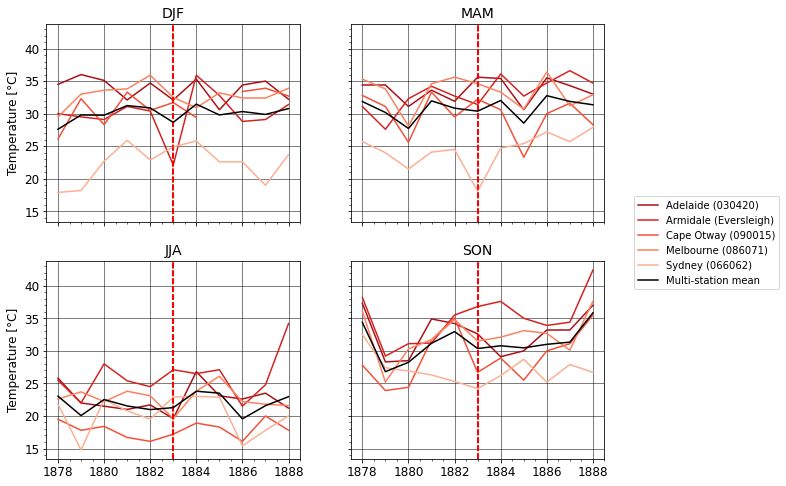

In [48]:
# plot by season
# define the datasets to plot on each graph
ds = K_ex_index_s.ETR
# ds2 = K_ex_index_s.DTR

row = 2 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 2
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(10,8)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(season=season_order[m-1])
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
#             ds2.sel(station=s).sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color=oranges[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
#         ds2.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k')

        axes[r, m-rmin].set(ylabel=None, title = season_order[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.15, 0.5)) 

plt.savefig('O_timeseries_monthly_DTR+msm_by_season.png', dpi=300, bbox_inches='tight')

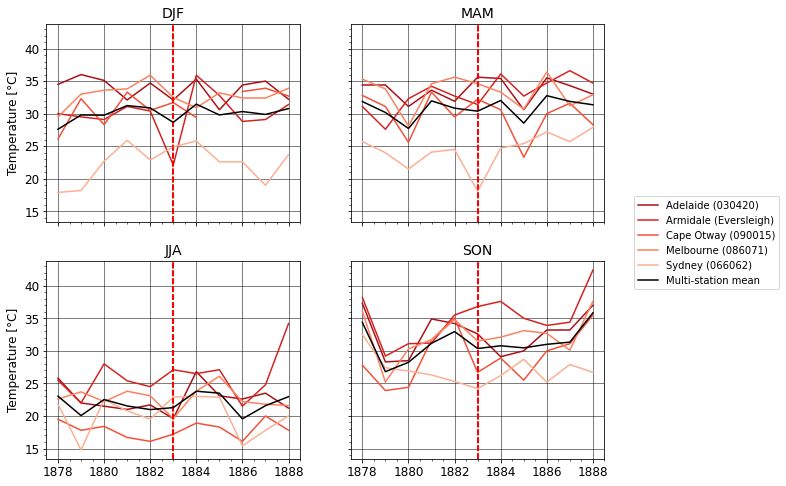

In [49]:
# plot by season
# define the datasets to plot on each graph
ds2 = K_ex_index_s.ETR
ds1 = K_ex_index_s.DTR

row = 2 # row must be 2 or more, otherwise need to just change axes indexing to axes[i] (instead of axes[i,j])
col = 2
fig, axes = plt.subplots(row, col, sharex=True, sharey=True, figsize=(10,8)) # make a figure
# select out eah month
rmin = 1
rmax = rmin+col

# loop over each row
for r in range(0,row): 
    # create a new axis for each month
    for m in range(rmin,rmax):
        # loop over each station and plot each one on the same month plot
        for i, s in enumerate(ds.station):
            dplot = ds.sel(station=s).sel(season=season_order[m-1])
            fplot.timeseries_noP(dplot, ax = axes[r, m-rmin], color=reds[i], label = s.data)
            # plot the second dataset 
#             ds2.sel(station=s).sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color=oranges[i], label = ' ')
        
        # plot the multi-station mean
        ds.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k', label = 'Multi-station mean')
#         ds2.mean(dim='station').sel(season=season_order[m-1]).plot(ax = axes[r, m-rmin], color='k')

        axes[r, m-rmin].set(ylabel=None, title = season_order[m-1])
        axes[r, m-rmin].set_xlabel(None)
        axes[r, m-rmin].grid(False, which='minor')
        
        # make one legend for all tables (just use last axis to get info)  
        handles, labels = axes[r, m-rmin].get_legend_handles_labels()
    
    # set the ylabel for every row 
    axes[r, 0].set(ylabel= f'Temperature [{deg}C]')

    rmin = rmax
    rmax = rmin+col

# first arg to bbox is x second is y (x,y)
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.15, 0.5)) 

# plt.savefig('O_timeseries_monthly_DTR+ETR+msm_by_season.png', dpi=300, bbox_inches='tight')